# YOLO v4 Tensorflow Lite 추론코드 테스트

---
### 0. 사전작업 
터미널에서 다음 코드를 실행하여 .weights 파일을 .tflite 포맷을 컨버젼합니다.

> python save_model.py --weights ./data/yolov4.weights --output ./checkpoints/yolov4-416-lite --input_size 416 --model yolov4 --framework tflite
> python convert_tflite.py --weights ./checkpoints/yolov4-416-lite --output ./checkpoints/yolov4-416.tflite

---
### 1. 라이브러리 로드 및 데이터 준비

In [2]:
import tensorflow as tf

from PIL import Image
import cv2
import numpy as np
import os
import boto3


**Note** TF lite runtime만 설치된 환경에서는 다음 코드를 통해 Interpreter를 생성함
```python
import tflite_runtime.interpreter as tflite
interpreter = tf.lite.Interpreter(model_path=weights)
```

추론테스트용 입력 이미지를 준비합니다.

In [7]:
image_file = 'data/images/kite.jpg'
image = cv2.imread(image_file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = cv2.resize(image, (416, 416))
image = image / 255.
images_data = np.asarray([image]).astype(np.float32)

In [120]:
class_names = {}
with open("./data/classes/coco.names", 'r') as data:
    for ID, name in enumerate(data):
            class_names[ID] = name.strip('\n')

class_names[33]

'kite'

---
### 2. 모델 로드 및 추론 실행
Tensorflow lite Interpreter를 선언하고 weights를 로드합니다.

In [3]:
weights = './checkpoints/yolov4-416.tflite' # path to weights file

interpreter = tf.lite.Interpreter(model_path=weights)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
# print(input_details)
# print(output_details)

추론용 입력 이미지를 interpreter의 input tensor로 세팅한 후 추론연산(invoke)을 실행합니다.

In [8]:
interpreter.set_tensor(input_details[0]['index'], images_data)
interpreter.invoke()

interpreter의 출력 노드(output_details)로부터 추론결과를 가져옵니다.

In [10]:
pred = [interpreter.get_tensor(output_details[i]['index']) for i in range(len(output_details))]

추론 결과는 bounding box 좌표와 해당 bounding box에 대한 80개 class 분류결과를 리턴합니다. 
> bounding box 포맷 : (x, y, width, height)  
> class 분류 결과 : 80개 class 에 대한 확률값 (argmax 적용 전)

In [11]:
pred

[array([[[  3.526263 ,   3.146238 ,   8.450197 ,   7.3718467],
         [ 11.697954 ,   2.7945168,  22.611118 ,   6.8323855],
         [ 19.163567 ,   2.4529858,  35.700657 ,   6.190065 ],
         ...,
         [333.95306  , 395.39197  , 230.65976  , 193.61404  ],
         [364.6481   , 394.38718  , 231.73586  , 209.97874  ],
         [396.71094  , 394.54666  , 250.67     , 262.81134  ]]],
       dtype=float32),
 array([[[2.0406207e-05, 2.8324169e-07, 4.6104315e-06, ...,
          1.6558438e-07, 4.0623224e-08, 5.6262053e-07],
         [6.1433575e-06, 7.1988445e-08, 1.1420927e-06, ...,
          4.2682920e-08, 8.9073744e-09, 5.3623111e-08],
         [5.9875019e-06, 5.9304064e-08, 8.3215832e-07, ...,
          3.9392699e-08, 6.2681877e-09, 3.5548602e-08],
         ...,
         [4.4116742e-08, 3.7850029e-10, 1.7677501e-09, ...,
          1.5611999e-10, 1.1658793e-10, 1.2913415e-10],
         [3.0141820e-08, 1.9263689e-10, 1.0418569e-09, ...,
          1.8141916e-10, 9.1858320e-11, 1.052

추론 결과(pred) 포맷 변환

In [34]:
bboxes = np.array([tuple(x) for x in pred[0][0]])
print(len(bboxes))
print(bboxes[:5])

10647
[[ 3.526263   3.146238   8.450197   7.3718467]
 [11.697954   2.7945168 22.611118   6.8323855]
 [19.163567   2.4529858 35.700657   6.190065 ]
 [27.505407   1.9395761 36.6512     5.3753214]
 [35.552452   1.5229988 34.455544   4.5798583]]


In [159]:
pred_classes = []
for c in pred[1][0]:
    pred_class = (int(np.argmax(c)), float(np.max(c)))
    pred_classes.append(pred_class)
pred_classes [:5]

[(33, 0.0001462509681005031),
 (33, 4.464658195502125e-05),
 (33, 2.7563455660128966e-05),
 (33, 6.707670763717033e-06),
 (33, 1.0996203627655632e-06)]

---
### 3. 추론결과 후처리

- confidence threshold기반 필터링
- x,y,w,h 를 x,y 의 min, max 좌표로 수정

In [160]:
def filter_boxes(bboxes, pred_classes, score_threshold = 0.4):
    class_boxes = []
    class_ids = []
    for i, box in enumerate(bboxes):
        if pred_classes[i][1] >= score_threshold:
            x1 = (box[0] - box[2]/2)/416
            y1 = (box[1] - box[3]/2)/416
            x2 = (box[0] + box[2]/2)/416
            y2 = (box[1] + box[3]/2)/416
            class_boxes.append([x1,y1,x2,y2]) 
            class_ids.append(pred_classes[i])
    
    return np.array(class_boxes), class_ids

class_boxes, class_ids = filter_boxes(bboxes, pred_classes)
class_boxes[:5]

array([[0.43591882, 0.08919803, 0.49712444, 0.16812927],
       [0.20689726, 0.26256541, 0.22676024, 0.31093658],
       [0.2071231 , 0.26398744, 0.22688737, 0.3159648 ],
       [0.3463357 , 0.3772436 , 0.35934669, 0.39720487],
       [0.42745857, 0.38221556, 0.44428339, 0.40842821]])

In [161]:
class_ids

[(33, 0.9309861063957214),
 (33, 0.8439842462539673),
 (33, 0.5988858938217163),
 (33, 0.7356628179550171),
 (33, 0.8796142339706421),
 (33, 0.5575621128082275),
 (33, 0.4003377854824066),
 (33, 0.6840341091156006),
 (0, 0.41316473484039307),
 (0, 0.8587328791618347),
 (0, 0.7857414484024048),
 (0, 0.7854229211807251),
 (0, 0.6374804377555847),
 (0, 0.463489830493927),
 (0, 0.4477907717227936),
 (0, 0.7637600898742676),
 (0, 0.6882723569869995),
 (33, 0.9807818531990051),
 (33, 0.5288606286048889),
 (33, 0.463715136051178),
 (0, 0.46457481384277344),
 (0, 0.6016947031021118),
 (0, 0.7255467772483826),
 (0, 0.9602358341217041),
 (0, 0.8661357760429382),
 (0, 0.9607294201850891),
 (0, 0.9232673645019531),
 (33, 0.9822863340377808),
 (0, 0.9490342736244202),
 (0, 0.8268519043922424),
 (0, 0.9500079154968262),
 (0, 0.8941727876663208),
 (33, 0.9888455271720886),
 (0, 0.9860107898712158),
 (0, 0.8001716136932373),
 (0, 0.9910551905632019),
 (33, 0.9570338726043701),
 (0, 0.9034570455551147)

- non max suppresion 등의 처리가 추가로 필요할 수 있음

---
### 4. 추론 결과 plot (확인용)

In [162]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import random

def plot_labels(cbxs, cids, threshold=0.4):
    img=mpimg.imread(image_file)
    ih, iw, _ = img.shape
    plt.imshow(img)

    for idx, cbx in enumerate(cbxs):
        x = cbx[0] * iw
        y = cbx[1] * ih
        w = cbx[2] * iw - x
        h = cbx[3] * ih - y
        rect = plt.Rectangle((x,y), w, h, fill=False, linewidth=1.5)
        plt.gca().add_patch(rect)
        plt.gca().text(x, y - 10, 
                       class_names[cids[idx][0]], 
                       bbox={'facecolor':'red', 'alpha':0.5},
                       fontsize=10, color='white')
    plt.show()

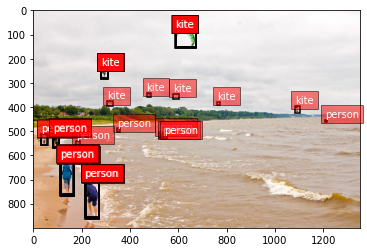

In [163]:
plot_labels(class_boxes, class_ids)

#### json.dumps 테스트(request body 생성용)

In [167]:
json.dumps({'class_boxes':class_boxes.tolist(),
            'class_ids':class_ids
           })

'{"class_boxes": [[0.4359188171533438, 0.08919802537331215, 0.4971244426874014, 0.16812927447832549], [0.20689725646605858, 0.2625654133466574, 0.22676024299401504, 0.3109365770450005], [0.20712310075759888, 0.26398744262181795, 0.22688736823888925, 0.31596479736841643], [0.34633569992505586, 0.37724359792012435, 0.3593466877937317, 0.3972048702148291], [0.42745856596873355, 0.3822155583363313, 0.4442833891281715, 0.40842820703983307], [0.2257757049340468, 0.4169818266079976, 0.2420332385943486, 0.4412486174931893], [0.5634138162892598, 0.41959245388324445, 0.5703239678763427, 0.4349488111642691], [0.801148591706386, 0.437325772184592, 0.8150033647051225, 0.4713256531036817], [0.8919313936852492, 0.5020405466739948, 0.8990724937847028, 0.5144350574566767], [0.25480800981705004, 0.5421252015691537, 0.2638684178774173, 0.5605009387318904], [0.3835653376120787, 0.5600144221232488, 0.395633088854643, 0.585326570730943], [0.023818660240906935, 0.5680102728880368, 0.042786045716359064, 0.617